## Optimizing Personalized Treatment Strategies for Acute Hypotensive Patients

Description of Environment:

1. State Space: The state space represents the current condition of the patient which includes:
    * Vital signs: Heart rate, systolic and diastolic blood pressure, respiratory rate, oxygen saturation, etc.
    * Biochemical markers: Blood pH, lactate levels, creatinine, and other lab results that provide insights into organ function
    * Demographics and medical history: Patient age, gender, weight, comorbidities (e.g. diabetes, renal failure)
    * Previous treatment: Prior medication dosages and fluid levels administered during the current ICU stay. 

2. Action Space: Discrete treatment actions that a clinician could take to manage acute hypotension in ICU patients. This may include: 
    * Fluid Administration (e.g. low, medium, high dosage)
    * Vasopressor administration (e.g. low, medium, high dosage)
    * No intervention (wait and observe)
    Each of these actions will have an immediate impact on the patient’s state (e.g. vital signs, biochemical markers), making it crucial to optimize the sequence of actions based on the patient’s evolving condition. 

3. Reward Function: The reward at time step $t$ is dependent on the Mean Arterial Pressure $MAP_t$ and is given by:

$$\text{reward}_t = \begin{cases}
0 & \text{if MAP$_t > 65$} \\
\frac{-0.05(65-\text{MAP}_t)}{5} & \text{if $60 < \text{MAP}_t \le 65$} \\
\frac{-0.1(60-\text{MAP}_t)}{5}-0.05 & \text{if $55 < \text{MAP}_t \le 60$} \\
\frac{-0.85(55-\text{MAP}_t)}{15}-0.15 & \text{if $\text{MAP}_t \le 55$} \\
\end{cases}$$

But the reward value is also dictated, and overwritten by the urine output at time step t:

$$\text{reward}_t = 0 \text{ if urine}_t >30\text{ and MAP}_t >55$$

The objective of the project is to develop an AI-based decision support system that assists clinicians in personalizing treatment strategies for acute hypotension. We will :

* Learn to recommend optimal treatments based on patient-specific data, adapting in real-time to their evolving condition.
* Compare the performance of model-free approaches with model-based techniques to identify which provides more reliable and clinically relevant reccomendations
* Use off-policy evaluation methods such as weighted importance sampling and bootstrapping to ensure safe and effective policies without real-world deployment. 


---

### 0. Split Train Test

In [2]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [3]:
# load data
df = df = pd.read_csv('Data/C001_FakeHypotension.csv')
print(f'Number of unique patients: {df["PatientID"].nunique()}')
num_patients = df['PatientID'].nunique()

# rename columns
df.rename(columns={"PatientID": "id", "Timepoints": "hour"}, inplace=True)

Number of unique patients: 3910


In [4]:
# reward function
def reward_function(row):
    if row.MAP > 65: # 0 at >65
        reward = 0
    elif row.MAP > 60: # -0.05 at 60 and 0 at 65
        reward = -0.05 * (65 - row.MAP) / 5
    elif row.MAP > 55: # -0.15 at 55 and -0.05 at 60
        reward = -0.10 * (60 - row.MAP) / 5 - 0.05
    else: # -1 at 40 and -0.15 at 55
        reward = -0.85 * (55 - row.MAP) / 15 - 0.15
    if row.urine > 30 and row.MAP > 55:
        reward = 0
    return reward

# add the reward to the data
df['reward'] = df.apply(lambda row: reward_function(row), axis=1)
# shift one up so that reward is in the same row of action
df['reward'] = df['reward'].shift(-1)

In [5]:
# encode action to action number
fluid_boluses_dict = {
    **dict.fromkeys([0, 1, 2, 3], '[0, 250)'),
    **dict.fromkeys([4, 5, 6, 7], '[250, 500)'),
    **dict.fromkeys([8, 9, 10, 11], '[500, 1000)'),
    **dict.fromkeys([12, 13, 14, 15], '>= 1000')
}
vasopressors_dict = {
    **dict.fromkeys([0, 4, 8, 12], '0'),
    **dict.fromkeys([1, 5, 9, 13], '(0, 8.4)'),
    **dict.fromkeys([2, 6, 10, 14], '[8.4, 20.28)'),
    **dict.fromkeys([3, 7, 11, 15], '>= 20.28')
}

fluid_boluses_mapping = {v:i for i,v in enumerate(sorted(df['fluid_boluses'].unique()))}
vasopressors_mapping = {v:i for i,v in enumerate(sorted(df['vasopressors'].unique()))}
df['fluid_boluses'] = df['fluid_boluses'].map(fluid_boluses_mapping)
df['vasopressors'] = df['vasopressors'].map(vasopressors_mapping)
df['action_number'] = 4 * df['fluid_boluses'] + df['vasopressors']

In [6]:
# split train test
seed = 42
np.random.seed(seed)

train_ratio = 0.8
num_train_samples = int(num_patients * train_ratio)
train_ids = np.random.choice(num_patients, num_train_samples)
print(f'Number of patients in train data: {len(train_ids)}')

train_df = df[df["id"].isin(train_ids)].reset_index(drop=True)
test_df = df[~df["id"].isin(train_ids)].reset_index(drop=True)

print(f'Train Data: {train_df.shape}')
print(f'Test Data: {test_df.shape}')

Number of patients in train data: 3128
Train Data: (101376, 25)
Test Data: (86304, 25)


### 1. Tabular Q-Learning (Following HealthGym's tutorial)

Prepare data:

In [7]:
from sklearn.cluster import KMeans
from sklearn.cross_decomposition import PLSCanonical

In [8]:
# cross decomposition to reduce dimensionality
actions = ["fluid_boluses", "vasopressors"]
states = ["MAP", "diastolic_bp", "systolic_bp", "urine", "ALT", "AST", "PO2", "lactic_acid", "serum_creatinine", "FiO2", 
          "GCS_total", "urine_m", "ALT_AST_m", "FiO2_m", "GCS_total_m", "PO2_m", "lactic_acid_m", "serum_creatinine_m"]

train_df_state = train_df[states]
train_df_action = train_df[actions]
train_df_action = pd.get_dummies(train_df_action, prefix=["fluid_boluses", "vasopressors"], columns=["fluid_boluses", "vasopressors"])

# partial least squares regression
plsca = PLSCanonical(n_components=5)

X = train_df_state.astype(float).values
Y = train_df_action.astype(float).values
X_norm = (X - X.mean(axis=0)) / (X.std(axis=0))
Y_norm = (Y - Y.mean(axis=0)) / (Y.std(axis=0))
X_canonical, Y_canonical = plsca.fit_transform(X_norm, Y_norm)

In [9]:
# k-means clustering to assign each patient to 1 cluster
num_states = 100
kmeans = KMeans(n_clusters=num_states, n_init=10, random_state=123)

state_numbers = kmeans.fit(X_canonical).labels_

We add the following variables:
* `hour`: time point between 0 and 47
* `action_number`: number between 0 and 15 indicating the action taken
* `state_number`: cluster asociated with the state at time t
* `state_number_tp1`: cluster associated with the state at time t+1

In [10]:
# add state number
X_train = train_df.copy()

X_train['state_number'] = state_numbers
X_train['state_number_tp1'] = X_train['state_number'].shift(-1)

X_train.head()

,Unnamed: 0,MAP,diastolic_bp,systolic_bp,urine,ALT,AST,PO2,lactic_acid,serum_creatinine,...,GCS_total_m,PO2_m,lactic_acid_m,serum_creatinine_m,id,hour,reward,action_number,state_number,state_number_tp1
0,48,39.952660,29.214905,108.805710,425.59628,19.907928,41.239155,99.31541,1.202458,0.925502,...,0,0,0,1,1,0,0.000000,8,24,49.0
1,49,68.468155,54.808110,101.934395,141.29442,28.589739,37.192097,95.09573,1.980157,1.350632,...,1,0,0,0,1,1,0.000000,1,49,24.0
2,50,57.901825,49.352460,98.348130,168.83945,21.603394,32.510864,116.30304,1.705058,1.007780,...,0,0,0,1,1,2,0.000000,1,24,75.0
3,51,64.464700,49.554610,104.063640,152.57677,29.738842,36.389750,115.09922,1.942347,1.357720,...,0,0,0,0,1,3,0.000000,1,75,19.0
4,52,77.893555,66.831276,115.173450,126.08959,27.832410,35.918148,98.64675,1.797520,1.080140,...,0,0,0,0,1,4,-1.100548,1,19,34.0


In [11]:
# ignore last hour since we don't observe reward of the last state
X_train = X_train[X_train["hour"] < 47]
X_train["state_number_tp1"] = X_train["state_number_tp1"].astype(int)

A simple algorithm for offline reinforcement learning (where we are given a fixed batch of data and can’t interact with the environment to collect new data) is Batch-Constrained Q-learning (BCQL). It determines an optimal policy in a way similar to standard Q-learning, except that the max over action values in the next state is taken only over actions that have actually been observed in the data.

In [12]:
# q-learning
Q = np.full((100, 16), np.nan, dtype='float') # 100 states, 16 actions

# Set to 0 if state-action combination has actually been observed in the data
for index, row in X_train.iterrows():
    state_number = int(row['state_number'])
    action_number = int(row['action_number'])
    Q[state_number, action_number] = 0

# parameters
num_iterations = 300
step_size = 0.1
gamma = 0.99
diff_tracker = np.zeros((num_iterations, 1))

# q-learning loop
for Q_iter in range(num_iterations):
    Q_old = Q.copy()
    for index, row in X_train.iterrows():
        state_number = int(row['state_number'])
        action_number = int(row['action_number'])
        state_number_tp1 = int(row['state_number_tp1'])
        Q[state_number, action_number] += step_size * (row['reward'] + gamma * np.nanmax(Q[state_number_tp1, :]) - Q[state_number, action_number])
    diff_tracker[Q_iter] = np.nanmean(np.abs(Q-Q_old))

    if (Q_iter > 0) and (Q_iter % 10 == 0):
        print(f"[Step {Q_iter}] Difference in Q-values: {diff_tracker[Q_iter][0]}")

[Step 10] Difference in Q-values: 0.0008632408002870604
[Step 20] Difference in Q-values: 0.00023965148263900245
[Step 30] Difference in Q-values: 7.853201287151403e-05
[Step 40] Difference in Q-values: 2.6852447632753353e-05
[Step 50] Difference in Q-values: 9.306193066916596e-06
[Step 60] Difference in Q-values: 3.239913197981494e-06
[Step 70] Difference in Q-values: 1.129728718751889e-06
[Step 80] Difference in Q-values: 3.941400201655222e-07
[Step 90] Difference in Q-values: 1.375335463348281e-07
[Step 100] Difference in Q-values: 4.799488981545824e-08
[Step 110] Difference in Q-values: 1.674908105095084e-08
[Step 120] Difference in Q-values: 5.845075310725627e-09
[Step 130] Difference in Q-values: 2.039811901279939e-09
[Step 140] Difference in Q-values: 7.118528491012444e-10
[Step 150] Difference in Q-values: 2.484220585316309e-10
[Step 160] Difference in Q-values: 8.669415435985847e-11
[Step 170] Difference in Q-values: 3.0254442232468724e-11
[Step 180] Difference in Q-values: 1.

**Evaluation**

The expected value of the RL policy can now be compared to the value of the original clinical policy or a random policy. The expected value of the RL policy is higher than for the other policies.

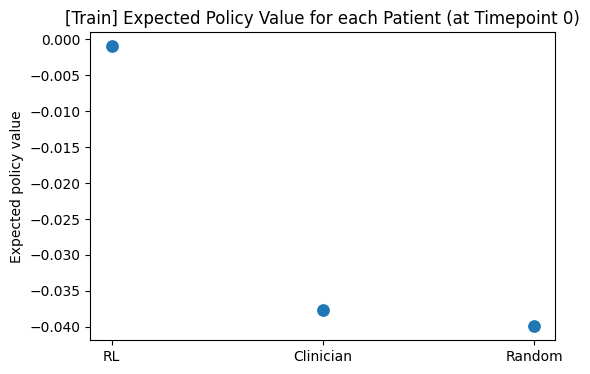

In [13]:
# evaluation on training data
Q_RL = 0
Q_random = 0
Q_clinician = 0

for index, row in X_train.iterrows():
    if row["hour"] == 0:
        # rl policy
        Q_RL += np.nanmax(Q[int(row['state_number']), :])

        # clinician policy
        Q_clinician += Q[int(row['state_number']), int(row['action_number'])]
        
        # random policy
        h = Q[int(row['state_number']), :]
        h = h[~np.isnan(h)]
        Q_random += h[np.random.choice(h.shape[0], 1)][0]

Q_RL = Q_RL / num_patients
Q_clinician = Q_clinician / num_patients
Q_random = Q_random / num_patients

plt.figure(figsize=(6, 4))
sns.scatterplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], markers='s', s=100)
plt.ylabel('Expected policy value')
plt.title('[Train] Expected Policy Value for each Patient (at Timepoint 0)')
plt.show()

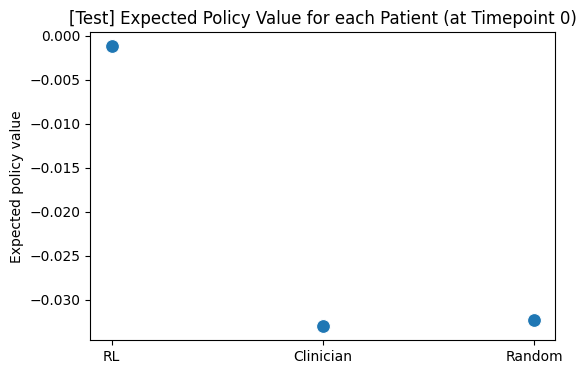

In [14]:
# normalize the test data
test_df_state = test_df[states]
X_test_state = test_df_state.astype(float).values
X_test_norm = (X_test_state - X.mean(axis=0)) / X.std(axis=0)

# apply PLSCanonical to test data
X_test_canonical = plsca.transform(X_test_norm)

# apply k-means to get state numbers
test_state_numbers = kmeans.predict(X_test_canonical)

# add state numbers to test data
X_test = test_df.copy()
X_test["state_number"] = test_state_numbers

# evaluation on test data
Q_RL = 0
Q_random = 0
Q_clinician = 0

for index, row in X_test.iterrows():
    if row["hour"] == 0:
        # rl policy
        Q_RL += np.nanmax(Q[int(row['state_number']), :])

        # clinician policy
        Q_clinician += Q[int(row['state_number']), int(row['action_number'])]
        
        # random policy
        h = Q[int(row['state_number']), :]
        h = h[~np.isnan(h)]
        Q_random += h[np.random.choice(h.shape[0], 1)][0]

Q_RL = Q_RL / num_patients
Q_clinician = Q_clinician / num_patients
Q_random = Q_random / num_patients

plt.figure(figsize=(6, 4))
sns.scatterplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], markers='s', s=100)
plt.ylabel('Expected policy value')
plt.title('[Test] Expected Policy Value for each Patient (at Timepoint 0)')
plt.show()

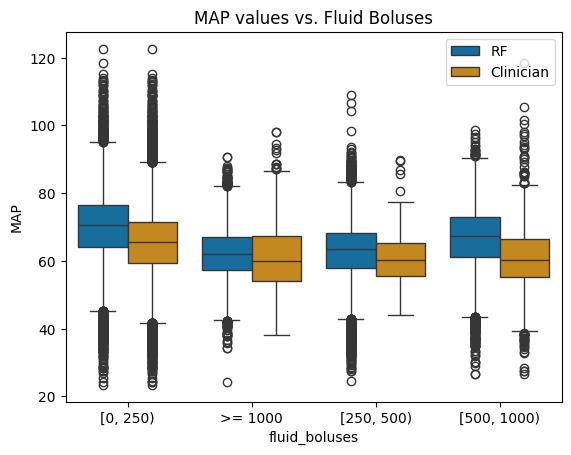

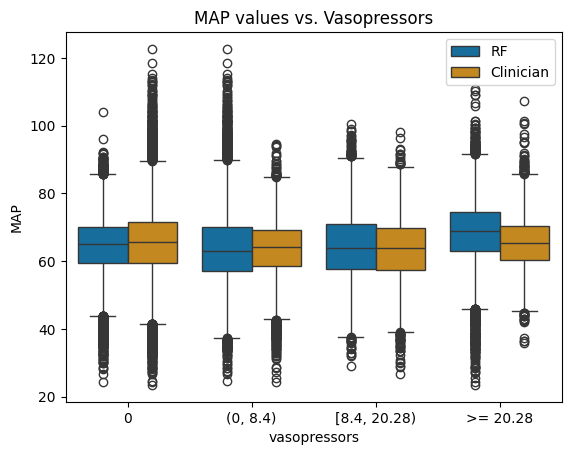

In [17]:
# MAP values for each action taken (test data)
df_boxplot_RF = X_test[['MAP']]
df_boxplot_RF['action_number'] = 0
for index, row in X_test.iterrows():
    df_boxplot_RF.at[index, 'action_number'] = np.nanargmax(Q[int(row['state_number']), :])

df_boxplot_RF['agent'] = 'RF'
df_boxplot_clinician = X_test[['MAP', 'action_number']]
df_boxplot_clinician['agent'] = 'Clinician'
df_boxplot = pd.concat([df_boxplot_RF, df_boxplot_clinician], ignore_index=True, sort=False)

df_boxplot['fluid_boluses'] = df_boxplot['action_number'].replace(fluid_boluses_dict)
df_boxplot['vasopressors'] = df_boxplot['action_number'].replace(vasopressors_dict)

sns.boxplot(y='MAP', x='fluid_boluses', data=df_boxplot, palette="colorblind", hue='agent')
plt.legend(loc="upper right")
plt.title("MAP values vs. Fluid Boluses")
plt.show()

sns.boxplot(y='MAP', x='vasopressors', data=df_boxplot, palette="colorblind", hue='agent', order=['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28'])
plt.legend(loc="upper right")
plt.title("MAP values vs. Vasopressors")
plt.show()

---

### 2. Discrete Batch Constrained Deep Q-Learning



In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import deque

Preprocess data - scale the state columns:

In [19]:
# transform the train and test data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(train_df[states]), columns=states)
X_test_scaled = pd.DataFrame(scaler.transform(test_df[states]), columns=states)

# add the necessary columns back
cols = ["id", "hour", "reward", "action_number"]
for col in cols:
    X_scaled[col] = train_df[col]
    X_test_scaled[col] = test_df[col]

Create a replay buffer and store all transitions:

In [20]:
# replay buffer method
class ReplayBuffer:
    def __init__(self, max_size=1000000, batch_size=32):
        self.buffer = deque(maxlen=max_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self):
        batch = random.sample(self.buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        # convert to tensors
        return (
            torch.FloatTensor(states),
            torch.LongTensor(actions),
            torch.FloatTensor(rewards),
            torch.FloatTensor(next_states),
            torch.FloatTensor(dones)
        )

    def __len__(self):
        return len(self.buffer)

In [21]:
# store the transitions in the training data into the replay buffer
replay_buffer = ReplayBuffer()

for idx, row in X_scaled.iterrows():
    # terminal state, we don't observe reward, ignore
    if row["hour"] == 47: 
        continue
    else:
        id = row["id"]
        hour = row["hour"]

        state = np.array(row[states].values)
        action = int(row["action_number"])
        reward = row["reward"]

        next_state_row = X_scaled[(X_scaled["id"]==id) & (X_scaled["hour"]==hour+1)]
        next_state = np.array(next_state_row[states].values[0])
        done = 0

        replay_buffer.add(state, action, reward, next_state, done)

Set up the offline RL agent:

In [22]:
# get the theoretical bounds of the q-values (we clamp the q-values for better convergence)
gamma = 0.99
v_min = X_scaled['reward'].min() / (1 - gamma)
v_max = X_scaled['reward'].max() / (1 - gamma)
print(f'Theoretical bounds of q-values: [{v_min}, {v_max}]')

Theoretical bounds of q-values: [-216.77837199999976, 0.0]


In [23]:
# behavior cloning model - outputs a distribution over the 16 discrete actions
class BehaviorCloning(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128, v_min=v_min, v_max=v_max):
        super(BehaviorCloning, self).__init__()
        self.v_min= v_min
        self.v_max = v_max
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
        
        # weight initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.uniform_(self.fc3.weight, -1e-2, 1e-2)  # Small weights for output layer
        nn.init.uniform_(self.fc3.bias, -1e-2, 1e-2)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.clamp(x, min=self.v_min, max=self.v_max)
    
class Q_Network(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128, v_min=v_min, v_max=v_max):
        super(Q_Network, self).__init__()
        self.v_min= v_min
        self.v_max = v_max
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
        
        # weight initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.uniform_(self.fc3.weight, -1e-2, 1e-2)  # Small weights for output layer
        nn.init.uniform_(self.fc3.bias, -1e-2, 1e-2)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.clamp(x, min=self.v_min, max=self.v_max)
    

# BCQ for discrete actions
class DiscreteBCQ:
    def __init__(self, state_dim, action_dim, hidden_dim=128, gamma=0.99, bcq_threshold=0.3, target_update_steps=5000, device="mps"):
        self.gamma = gamma
        self.threshold = bcq_threshold
        self.target_update_steps = target_update_steps
        self.device = device

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.q_network = Q_Network(state_dim, action_dim, hidden_dim).to(device)
        self.target_q_network = Q_Network(state_dim, action_dim, hidden_dim).to(device)
        self.behavior_model = BehaviorCloning(state_dim, action_dim, hidden_dim).to(device)

        self.q_optimizer = optim.Adam(self.q_network.parameters(), lr=1e-5)
        self.behavior_optimizer = optim.Adam(self.behavior_model.parameters(), lr=1e-5)

        # copy weights to target model
        self.target_q_network.load_state_dict(self.q_network.state_dict())

        # losses
        self.q_losses = []
        self.behavior_losses = []
        self.losses = []

    def select_action(self, states):
        # select action according to policy
        with torch.no_grad():
            # get q values from q-network (using current q_network as in Double DQN)
            q_values = self.q_network(states)

            # calculate action probabilities from behavior model
            behavior_logits = self.behavior_model(states)
            log_action_probs = F.log_softmax(behavior_logits, dim=1)

            # Normalize the log probabilities by subtracting the maximum log probability
            ratio = log_action_probs - log_action_probs.max(dim=1, keepdim=True).values
            # create a mask 
            mask = (ratio > np.log(self.threshold)).float()

            # normalize the q-values by subtracting the min Q-values across actions
            normalized_q_values = q_values - q_values.min(dim=1, keepdim=True).values

            # Apply the mask: zero out Q-values for invalid actions
            masked_q_values = normalized_q_values * mask

            # Select the action with the highest masked Q-value
            next_actions = masked_q_values.argmax(dim=1)
            
            return next_actions
    
    def save_model(self, filepath):
        """Save the Q-network and Target-network to the specified filepath."""
        torch.save({
            'q_network': self.q_network.state_dict(),
            'target_network': self.target_q_network.state_dict(),
            'behavior_network': self.behavior_model.state_dict(),
            'optimizer': self.q_optimizer.state_dict(),
            'behavior_optimizer': self.behavior_optimizer.state_dict()
        }, filepath)

    def load_model(self, filepath):
        """Load the Q-network and Target-network from the specified filepath."""
        checkpoint = torch.load(filepath, map_location=self.device)
        self.q_network.load_state_dict(checkpoint['q_network'])
        self.target_q_network.load_state_dict(checkpoint['target_network'])
        self.behavior_model.load_state_dict(checkpoint['behavior_network'])
        if 'optimizer' in checkpoint:
            self.q_optimizer.load_state_dict(checkpoint['optimizer'])
            self.behavior_optimizer.load_state_dict(checkpoint['behavior_optimizer'])
              
    def train(self, replay_buffer, num_steps):
        for iteration in range(num_steps):
            # sample from replay buffer
            states, actions, rewards, next_states, dones = replay_buffer.sample()
            states, actions, rewards, next_states, dones = states.to(self.device), actions.to(self.device), rewards.to(self.device), next_states.to(self.device), dones.to(self.device)

            # behavior cloning (cross-entropy loss with one-hot actions)
            behavior_logits = self.behavior_model(states)
            log_probs = F.log_softmax(behavior_logits, dim=1)
            penalty = (behavior_logits ** 2).mean()
            behavior_loss = F.nll_loss(log_probs, actions) + 0.5 * penalty

            # update behavior model
            self.behavior_optimizer.zero_grad()
            behavior_loss.backward()
            self.behavior_optimizer.step()

            # select next action using behavior model
            next_actions = self.select_action(next_states)

            # compute q-targets
            with torch.no_grad():
                q_values_next = self.target_q_network(next_states)
                q_values_next = q_values_next.gather(1, next_actions.unsqueeze(1)).squeeze(1)
                q_targets = rewards + (self.gamma * (1 - dones) * q_values_next)

            # compute current q estimates
            q_current = self.q_network(states)
            q_current = q_current.gather(1, actions.unsqueeze(1)).squeeze(1)

            # q loss
            q_loss = F.smooth_l1_loss(q_current, q_targets) 

            # update q-network
            self.q_optimizer.zero_grad()
            q_loss.backward()
            self.q_optimizer.step()

            # hard update for target q
            if (iteration > 0) and (iteration % self.target_update_steps == 0):
                self.target_q_network.load_state_dict(self.q_network.state_dict())

            # store loss
            self.q_losses.append(q_loss.item())
            self.behavior_losses.append(behavior_loss.item())
            self.losses.append(q_loss.item() + behavior_loss.item())

            if (iteration > 0) and (iteration % 5000 == 0):
                avg_q_loss = sum(self.q_losses[-5000:]) / 5000
                avg_b_loss = sum(self.behavior_losses[-5000:]) / 5000
                total_avg_loss = sum(self.losses[-5000:]) / 5000
                print(f'[Step {iteration}/{num_steps}] Loss: {total_avg_loss:.8f}\tAvg Q-Loss: {avg_q_loss:.8f}\tAvg Imitator Loss: {avg_b_loss:.8f}')

In [24]:
# train the agent
discrete_bcq_agent = DiscreteBCQ(state_dim=18, action_dim=16, hidden_dim=128)
discrete_bcq_agent.train(replay_buffer, num_steps=200000)

[Step 5000/200000] Loss: 2.52497353	Avg Q-Loss: 0.01475858	Avg Imitator Loss: 2.51021495
[Step 10000/200000] Loss: 2.45857133	Avg Q-Loss: 0.01457845	Avg Imitator Loss: 2.44399288
[Step 15000/200000] Loss: 2.45191977	Avg Q-Loss: 0.01423254	Avg Imitator Loss: 2.43768723
[Step 20000/200000] Loss: 2.44919892	Avg Q-Loss: 0.01417496	Avg Imitator Loss: 2.43502396
[Step 25000/200000] Loss: 2.44707037	Avg Q-Loss: 0.01421307	Avg Imitator Loss: 2.43285730
[Step 30000/200000] Loss: 2.44640024	Avg Q-Loss: 0.01407417	Avg Imitator Loss: 2.43232607
[Step 35000/200000] Loss: 2.44370923	Avg Q-Loss: 0.01414717	Avg Imitator Loss: 2.42956205
[Step 40000/200000] Loss: 2.44356824	Avg Q-Loss: 0.01373090	Avg Imitator Loss: 2.42983734
[Step 45000/200000] Loss: 2.44220329	Avg Q-Loss: 0.01398304	Avg Imitator Loss: 2.42822024
[Step 50000/200000] Loss: 2.44131641	Avg Q-Loss: 0.01376866	Avg Imitator Loss: 2.42754775
[Step 55000/200000] Loss: 2.44039604	Avg Q-Loss: 0.01354638	Avg Imitator Loss: 2.42684966
[Step 60000

In [31]:
# save agent
torch.save(discrete_bcq_agent, "DiscreteBCQ/bcq_agent.pth")
discrete_bcq_agent.save_model(filepath="DiscreteBCQ/models.pth")

**Evaluation**

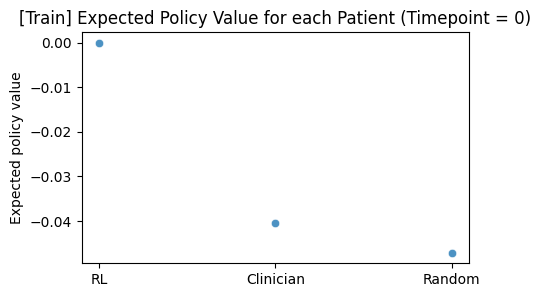

In [29]:
# evaluation on training
Q_RL = 0
Q_random = 0
Q_clinician = 0

# set model to evaluation
discrete_bcq_agent.q_network.eval()

for idx, row in X_scaled.iterrows():
    if row["hour"] == 0:
        state = np.array(row[states].values)
        state = torch.FloatTensor(state).unsqueeze(0).to(discrete_bcq_agent.device)
        action = int(row["action_number"])
        action = torch.LongTensor([action]).to(discrete_bcq_agent.device)

        with torch.no_grad():
            q_values = discrete_bcq_agent.q_network(state)
            max_q_value = torch.max(q_values).item()
            clinician_q_value = q_values.gather(1, action.unsqueeze(1)).item()
            random_q_value = np.random.choice(q_values[0].cpu())

            Q_RL += max_q_value
            Q_random += random_q_value
            Q_clinician += clinician_q_value

# normalize by number of patient
Q_RL /= num_patients
Q_clinician /= num_patients
Q_random /= num_patients

# Visualization
plt.figure(figsize=(5, 3))
sns.scatterplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], alpha=0.8)
plt.ylabel('Expected policy value')
plt.title('[Train] Expected Policy Value for each Patient (Timepoint = 0)')
plt.show()

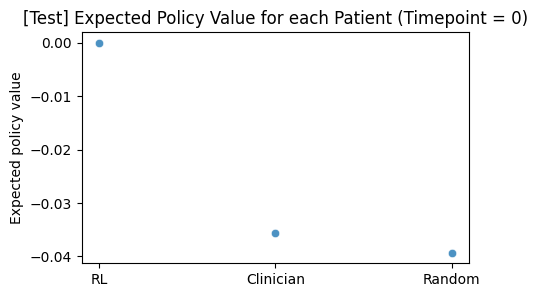

In [30]:
# evaluate for test
Q_RL = 0
Q_random = 0
Q_clinician = 0

# set model to evaluation
discrete_bcq_agent.q_network.eval()

for idx, row in X_test_scaled.iterrows():
    if row["hour"] == 0:
        state = np.array(row[states].values)
        state = torch.FloatTensor(state).unsqueeze(0).to(discrete_bcq_agent.device)
        action = int(row["action_number"])
        action = torch.LongTensor([action]).to(discrete_bcq_agent.device)

        with torch.no_grad():
            q_values = discrete_bcq_agent.q_network(state)
            max_q_value = torch.max(q_values).item()
            clinician_q_value = q_values.gather(1, action.unsqueeze(1)).item()
            random_q_value = np.random.choice(q_values[0].cpu())

            Q_RL += max_q_value
            Q_random += random_q_value
            Q_clinician += clinician_q_value

# normalize by number of patient
Q_RL /= num_patients
Q_clinician /= num_patients
Q_random /= num_patients

# Visualization
plt.figure(figsize=(5, 3))
sns.scatterplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], alpha=0.8)
plt.ylabel('Expected policy value')
plt.title('[Test] Expected Policy Value for each Patient (Timepoint = 0)')
plt.show()

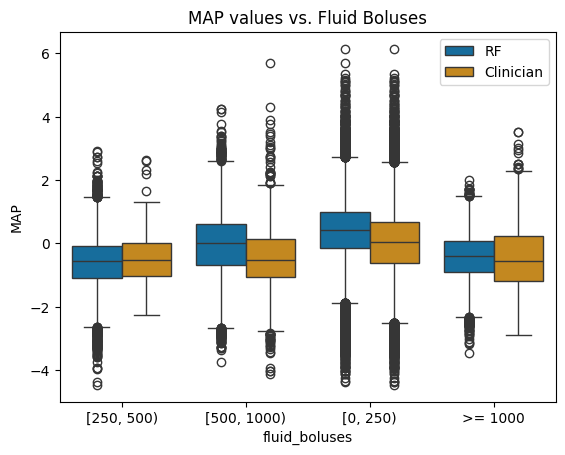

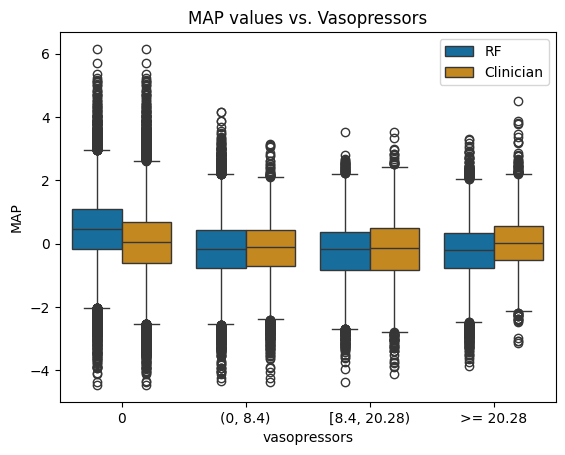

In [32]:
# MAP values for each action taken (test data)
df_boxplot_RF = X_test_scaled[['MAP']]
df_boxplot_RF['action_number'] = 0

for index, row in X_test_scaled.iterrows():
    state = np.array(row[states].values)
    state = torch.FloatTensor(state).unsqueeze(0).to(discrete_bcq_agent.device)
    action = int(row["action_number"])
    action = torch.LongTensor([action]).to(discrete_bcq_agent.device)

    with torch.no_grad():
        q_values = discrete_bcq_agent.q_network(state)
        rl_action = torch.argmax(q_values).item()

    df_boxplot_RF.at[index, 'action_number'] = rl_action

df_boxplot_RF['agent'] = 'RF'
df_boxplot_clinician = X_test_scaled[['MAP', 'action_number']]
df_boxplot_clinician['agent'] = 'Clinician'
df_boxplot = pd.concat([df_boxplot_RF, df_boxplot_clinician], ignore_index=True, sort=False)

df_boxplot['fluid_boluses'] = df_boxplot['action_number'].replace(fluid_boluses_dict)
df_boxplot['vasopressors'] = df_boxplot['action_number'].replace(vasopressors_dict)

sns.boxplot(y='MAP', x='fluid_boluses', data=df_boxplot, palette="colorblind", hue='agent')
plt.legend(loc="upper right")
plt.title("MAP values vs. Fluid Boluses")
plt.show()

sns.boxplot(y='MAP', x='vasopressors', data=df_boxplot, palette="colorblind", hue='agent', order=['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28'])
plt.legend(loc="upper right")
plt.title("MAP values vs. Vasopressors")
plt.show()

---

### 3. Conservative Q-Learning

Base Model: DoubleDQN

In [33]:
class DiscreteCQL:
    def __init__(self, state_dim, action_dim, hidden_dim=128, gamma=0.99, alpha=10.0, target_update_freq=1000, device="mps"):
        self.gamma = gamma
        self.alpha = alpha
        self.device = device
        self.target_update_freq = target_update_freq

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.q_network = Q_Network(state_dim, action_dim, hidden_dim).to(self.device)
        self.target_network = Q_Network(state_dim, action_dim, hidden_dim).to(self.device)

        # copy weights to target model
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=1e-5)

        # losses
        self.td_losses = []
        self.conservative_losses = []
        self.cql_losses = []

    def compute_loss(self, states, actions, rewards, next_states, dones):
        # 1. calculate bellman error (td error)
        # compute q-values for current states
        q_values = self.q_network(states)
        curr_q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

        # compute next q-values using target network using action selected by current q_network (DDQN framework to reduce overestimation)
        with torch.no_grad():
            next_q_values_q_network = self.q_network(next_states)
            next_actions = next_q_values_q_network.argmax(dim=1)
            next_q_values_target = self.target_network(next_states)
            next_q_values = next_q_values_target.gather(1, next_actions.unsqueeze(1)).squeeze(1)
        
        # compute td error
        td_target = rewards + (self.gamma * next_q_values * (1 - dones))
        td_error = F.mse_loss(curr_q_values, td_target)

        # 2. conservative loss: penalize over-estimation of OOD actions
        logsumexp_q_values = torch.logsumexp(q_values, dim=1)
        conservative_loss = (logsumexp_q_values - curr_q_values).mean()

        # 3. total loss
        cql_loss = td_error + self.alpha * conservative_loss
        return cql_loss, td_error, conservative_loss
    
    def train(self, replay_buffer, num_steps):
        for iteration in range(num_steps):
            # sample from replay buffer
            states, actions, rewards, next_states, dones = replay_buffer.sample()
            states, actions, rewards, next_states, dones = states.to(self.device), actions.to(self.device), rewards.to(self.device), next_states.to(self.device), dones.to(self.device)

            # compute loss
            cql_loss, td_loss, conservative_loss = self.compute_loss(states, actions, rewards, next_states, dones)

            # optimize
            self.optimizer.zero_grad()
            cql_loss.backward()
            self.optimizer.step()

            # update target network
            if (iteration > 0) and (iteration % self.target_update_freq == 0):
                self.target_network.load_state_dict(self.q_network.state_dict())

            # store and log loss
            self.cql_losses.append(cql_loss.item())
            self.td_losses.append(td_loss.item())
            self.conservative_losses.append(conservative_loss.item())

            if (iteration > 0) and (iteration % 1000 == 0):
                avg_td_loss = sum(self.td_losses[-1000:]) / 1000
                avg_cons_loss = sum(self.conservative_losses[-1000:]) / 1000
                avg_total_loss = sum(self.cql_losses[-1000:]) / 1000
                print(f'[Step {iteration}/{num_steps}] Total Loss: {avg_total_loss:.7f}\tTD Loss: {avg_td_loss:.7f}\tConservative Loss: {avg_cons_loss:.7f}')

    def save_model(self, filepath):
        """Save the Q-network and Target-network to the specified filepath."""
        torch.save({
            'q_network': self.q_network.state_dict(),
            'target_network': self.target_network.state_dict(),
            'optimizer': self.optimizer.state_dict()  # Optional: to save optimizer state too
        }, filepath)

    def load_model(self, filepath):
        """Load the Q-network and Target-network from the specified filepath."""
        checkpoint = torch.load(filepath, map_location=self.device)
        self.q_network.load_state_dict(checkpoint['q_network'])
        self.target_network.load_state_dict(checkpoint['target_network'])
        if 'optimizer' in checkpoint:
            self.optimizer.load_state_dict(checkpoint['optimizer'])

In [34]:
# train discrete cql agent
discrete_cql_agent = DiscreteCQL(state_dim=18, action_dim=16)
discrete_cql_agent.train(replay_buffer, num_steps=200000)

[Step 1000/200000] Total Loss: 26.4579350	TD Loss: 0.0355480	Conservative Loss: 2.6422387
[Step 2000/200000] Total Loss: 20.7776910	TD Loss: 0.1186406	Conservative Loss: 2.0659050
[Step 3000/200000] Total Loss: 16.1101466	TD Loss: 0.4222055	Conservative Loss: 1.5687941
[Step 4000/200000] Total Loss: 14.6934174	TD Loss: 0.6328969	Conservative Loss: 1.4060521
[Step 5000/200000] Total Loss: 14.1268718	TD Loss: 0.6862379	Conservative Loss: 1.3440634
[Step 6000/200000] Total Loss: 13.8701968	TD Loss: 0.7086761	Conservative Loss: 1.3161521
[Step 7000/200000] Total Loss: 13.7117902	TD Loss: 0.7123366	Conservative Loss: 1.2999454
[Step 8000/200000] Total Loss: 13.5053147	TD Loss: 0.6804324	Conservative Loss: 1.2824882
[Step 9000/200000] Total Loss: 13.5361740	TD Loss: 0.7138502	Conservative Loss: 1.2822324
[Step 10000/200000] Total Loss: 13.3705535	TD Loss: 0.6894751	Conservative Loss: 1.2681078
[Step 11000/200000] Total Loss: 13.4374933	TD Loss: 0.6977135	Conservative Loss: 1.2739780
[Step 12

In [35]:
# save model
torch.save(discrete_cql_agent, "DiscreteCQL/cql_agent.pth")
discrete_cql_agent.save_model(filepath="DiscreteCQL/model.pth")

Evaluation:

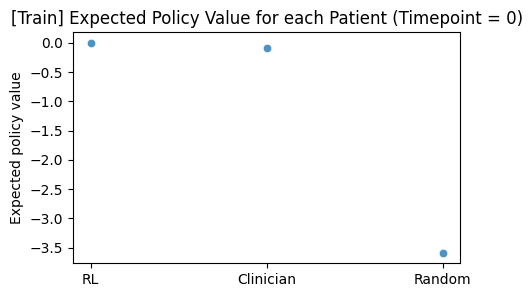

In [36]:
# evaluation on training
Q_RL = 0
Q_random = 0
Q_clinician = 0

# set model to evaluation
discrete_cql_agent.q_network.eval()

for idx, row in X_scaled.iterrows():
    if row["hour"] == 0:
        state = np.array(row[states].values)
        state = torch.FloatTensor(state).unsqueeze(0).to(discrete_cql_agent.device)
        action = int(row["action_number"])
        action = torch.LongTensor([action]).to(discrete_cql_agent.device)

        with torch.no_grad():
            q_values = discrete_cql_agent.q_network(state)
            max_q_value = torch.max(q_values).item()
            clinician_q_value = q_values.gather(1, action.unsqueeze(1)).item()
            random_q_value = np.random.choice(q_values[0].cpu())

            Q_RL += max_q_value
            Q_random += random_q_value
            Q_clinician += clinician_q_value

# normalize by number of patient
Q_RL /= num_patients
Q_clinician /= num_patients
Q_random /= num_patients

# Visualization
plt.figure(figsize=(5, 3))
sns.scatterplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], alpha=0.8)
plt.ylabel('Expected policy value')
plt.title('[Train] Expected Policy Value for each Patient (Timepoint = 0)')
plt.show()

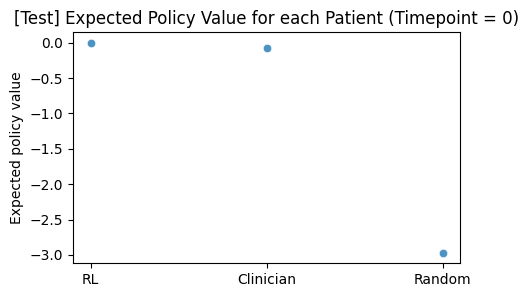

In [37]:
# evaluate for test
Q_RL = 0
Q_random = 0
Q_clinician = 0

# set model to evaluation
discrete_cql_agent.q_network.eval()

for idx, row in X_test_scaled.iterrows():
    if row["hour"] == 0:
        state = np.array(row[states].values)
        state = torch.FloatTensor(state).unsqueeze(0).to(discrete_cql_agent.device)
        action = int(row["action_number"])
        action = torch.LongTensor([action]).to(discrete_cql_agent.device)

        with torch.no_grad():
            q_values = discrete_cql_agent.q_network(state)
            max_q_value = torch.max(q_values).item()
            clinician_q_value = q_values.gather(1, action.unsqueeze(1)).item()
            random_q_value = np.random.choice(q_values[0].cpu())

            Q_RL += max_q_value
            Q_random += random_q_value
            Q_clinician += clinician_q_value

# normalize by number of patient
Q_RL /= num_patients
Q_clinician /= num_patients
Q_random /= num_patients

# Visualization
plt.figure(figsize=(5, 3))
sns.scatterplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], alpha=0.8)
plt.ylabel('Expected policy value')
plt.title('[Test] Expected Policy Value for each Patient (Timepoint = 0)')
plt.show()

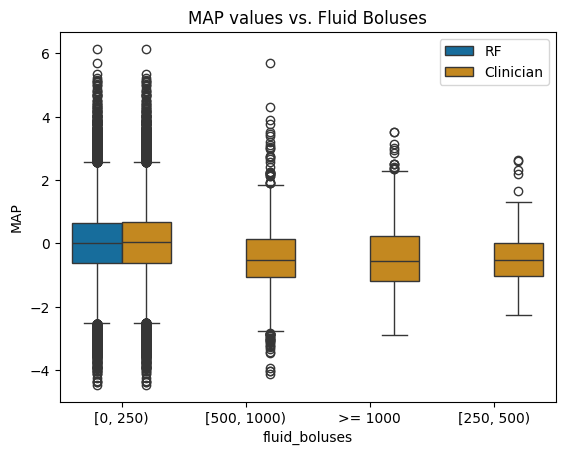

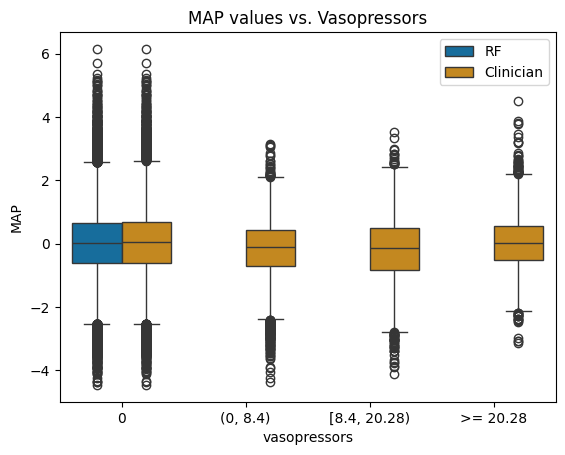

In [38]:
# MAP values for each action taken (test data)
df_boxplot_RF = X_test_scaled[['MAP']]
df_boxplot_RF['action_number'] = 0

for index, row in X_test_scaled.iterrows():
    state = np.array(row[states].values)
    state = torch.FloatTensor(state).unsqueeze(0).to(discrete_cql_agent.device)
    action = int(row["action_number"])
    action = torch.LongTensor([action]).to(discrete_cql_agent.device)

    with torch.no_grad():
        q_values = discrete_cql_agent.q_network(state)
        rl_action = torch.argmax(q_values).item()

    df_boxplot_RF.at[index, 'action_number'] = rl_action

df_boxplot_RF['agent'] = 'RF'
df_boxplot_clinician = X_test_scaled[['MAP', 'action_number']]
df_boxplot_clinician['agent'] = 'Clinician'
df_boxplot = pd.concat([df_boxplot_RF, df_boxplot_clinician], ignore_index=True, sort=False)

df_boxplot['fluid_boluses'] = df_boxplot['action_number'].replace(fluid_boluses_dict)
df_boxplot['vasopressors'] = df_boxplot['action_number'].replace(vasopressors_dict)

sns.boxplot(y='MAP', x='fluid_boluses', data=df_boxplot, palette="colorblind", hue='agent')
plt.legend(loc="upper right")
plt.title("MAP values vs. Fluid Boluses")
plt.show()

sns.boxplot(y='MAP', x='vasopressors', data=df_boxplot, palette="colorblind", hue='agent', order=['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28'])
plt.legend(loc="upper right")
plt.title("MAP values vs. Vasopressors")
plt.show()

___

### Evaluation